# Metaprogrammation

Définition de wikipédia : La métaprogrammation, nommée par analogie avec les métadonnées et les métaclasses, désigne l'écriture de programmes qui manipulent des données décrivant elles-mêmes des programmes. Dans le cas particulier où le programme manipule ses propres instructions pendant son exécution, on parle de programme auto-modifiant.

La métaprogrammation est beaucoup utilisé dans le langage **Julia**, c'est elle qui vous donne accès à toutes ces macros commencant par `@` si pratiques. Cependant, elle est à utiliser avec précaution car il est souvent difficile de détecter des erreurs. Je conseille de l'utiliser uniquement si cela est vraiment nécessaire.

In [1]:
using Plots

Nous allons coder en **Julia** quelques méthodes numériques classiques pour résoudre l'équation différentielle suivante:

$$
y'(t) = 1 - y(t)
$$

$ t \in [0,5] \qquad \mbox{ and } \qquad y(0) = 0 $

## Euler explicite

In [2]:
"""

   euler(f::Function, t::Float64, y::Float64, h::Float64)

explicit euler method function that returns

```math
y^{n+1} = y^n + h \\cdot f(t^n, y^n)
```

"""
function euler(f::Function, t::Float64, y::Float64, h::Float64)
    t + h, y + h * f(t,y)
end

euler

In [3]:
?euler

search: euler schedule NamedTuple promote_rule baremodule @NamedTuple



euler(f::Function, t::Float64, y::Float64, h::Float64)

explicit euler method function that returns

$$
y^{n+1} = y^n + h \cdot f(t^n, y^n)
$$


## Runge-Kutta d'ordre deux

In [4]:
"""

   rk2(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta second order method function

```jldoctest
julia> f(t,y) = 1 - y
julia> rk2(f, 0.0, 0.0, 1.0)
(1.0, 0.5)
```

"""
function rk2(f::Function, t::Float64, y::Float64,  h::Float64)
    ỹ = y + h/2 * f(t,y)
    t + h, y + h * f(t+h/2,ỹ)
end
#----------------------------------------------------------------------------

rk2

In [5]:
?rk2

search: rk2



rk2(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta second order method function

```jldoctest
julia> f(t,y) = 1 - y
julia> rk2(f, 0.0, 0.0, 1.0)
(1.0, 0.5)
```


## Runge-Kutta d'ordre quatre

In [6]:
"""

   rk4(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta fourth order method function

[Runge–Kutta methods on Wikipedia](https://en.wikipedia.org/wiki/Runge–Kutta_methods)

"""
function rk4(f::Function, t::Float64, y::Float64,  dt::Float64)

    y₁ = dt * f(t,y)
    y₂ = dt * f(t+dt/2,y+y₁/2)
    y₃ = dt * f(t+dt/2,y+y₂/2)
    y₄ = dt * f(t+dt,y+y₃)

    t+dt, y+(y₁+2*y₂+2*y₃+y₄)/6

end


rk4

In [7]:
?rk4

search: rk4



rk4(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta fourth order method function

[Runge–Kutta methods on Wikipedia](https://en.wikipedia.org/wiki/Runge–Kutta_methods)


## Fonction solveur

Voici une fonction  permettant de résoudre l'équation différentielle avec la méthode numérique utilisée en paramètre.

In [8]:
"""

    solver(f::Function, Method::Function, t₀::Float64,
                y₀::Float64, dt::Float64, nsteps::Int64)

Solve numerically the equation ``y' = f(t, y)``

with `y(t₀)= y₀` and `nsteps` steps `h`

## Arguments
- `f::Function`: the function `f` of equation ``y' = f(t,y)``.
- `Method::Function`: numerical method from (tⁿ,yⁿ) returns ``(t^{n+1},y^{n+1})``


"""
function solver(f::Function,
                Method::Function,
                t₀::Float64,
                y₀::Float64, h::Float64, nsteps::Int64)

    t = zeros(Float64,nsteps)
    y = similar(t)

    t[1] = t₀
    y[1] = y₀

    for i in 2:nsteps
       t[i], y[i] = Method(f,t[i-1],y[i-1], h)
    end

    t, y

end

solver

In [9]:
?solver

search: solver



```
solver(f::Function, Method::Function, t₀::Float64,
            y₀::Float64, dt::Float64, nsteps::Int64)
```

Solve numerically the equation $y' = f(t, y)$

with `y(t₀)= y₀` and `nsteps` steps `h`

## Arguments

  * `f::Function`: the function `f` of equation $y' = f(t,y)$.
  * `Method::Function`: numerical method from (tⁿ,yⁿ) returns $(t^{n+1},y^{n+1})$


In [10]:
nsteps, tfinal   = 7, 5.0
t₀, x₀ = 0., 0.

(0.0, 0.0)

In [11]:
dt = tfinal / (nsteps-1)
f(t, x) = 1 - x

f (generic function with 1 method)

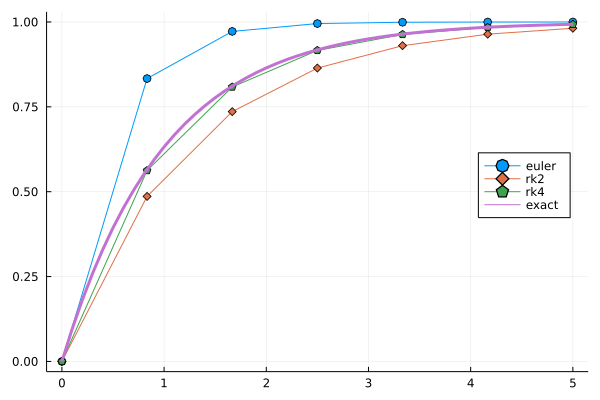

In [12]:
plot( solver(f, euler, t₀, x₀, dt, nsteps); marker = :o, label="euler")
plot!(solver(f, rk2,   t₀, x₀, dt, nsteps); marker = :d, label="rk2")
plot!(solver(f, rk4,   t₀, x₀, dt, nsteps); marker = :p, label="rk4")
t = 0:0.1:5
plot!(t, 1 .- exp.(-t); line = 3, label = "exact", legend = :right)

## Objet function

Pour améliorer l'interface, imaginons un type `RungeKutta` capable de fournir plusieurs méthodes de ce type.
Un schéma de Runge-Kutta peut se construire en utilisant le tableau de Butcher:

$$
\begin{array}{c|cccc}
 c₁  &        &        &        &        \\
 c₂  & a_{21} &        &        &        \\
 c₃  & a_{31} & a_{32} &        &        \\
 c₄  & a_{41} & a_{42} & a_{43} &        \\
 \hline
     & b_1    & b_2    & b_3    & b_4    \\
\end{array}
$$

$$
\forall i = 1, \dotsc, q, \begin{cases}t_{n,i} &= t_n + c_i h_n, \\ 
y_{n,i} &= y_n + h_n \sum_{k = 1}^{i-1} a_{ik} p_{n,k}\\ 
p_{n,i} &= f(t_{n,i}, y_{n,i}) \end{cases}
$$

$$
y_{n+1} = y_n + h_n \sum_{k = 1}^q b_k p_{n,k}.
$$


In [14]:
struct RungeKutta{T}
    
    q :: Int
    a :: Array{T, 2}
    b :: Array{T, 1}
    c :: Array{T, 1}
    
    tn :: Vector{T}
    yn :: Vector{T}
    pn :: Vector{T}
    
    function RungeKutta( a::Array{T,2}, b::Vector{T}, c::Vector{T}) where T
        
        q = length(c)
        @assert ( length(c) == size(a,1))
        @assert ( length(b) == size(a,2))
        tn = zeros(T, q)
        yn = zeros(T, q)
        pn = zeros(T, q)
        new{T}( q, a, b, c, tn, yn, pn)
        
    end

end

In [15]:
function (rk::RungeKutta)(f::Function, t::T, y::T,  h::T) where T

    for i = 1:rk.q
        rk.tn[i] = t + rk.c[i] * h
        rk.yn[i] = y + h * sum([rk.a[i,k]*rk.pn[k] for k = 1:i-1])
        rk.pn[i] = f(rk.tn[i],rk.yn[i])
    end

    t + h, y + h * sum([rk.b[k]*rk.pn[k] for k in 1:rk.q ])

end

In [16]:
function solver(f::Function,
                Method::RungeKutta,
                t₀::T,
                y₀::T, h::T, nsteps::Int) where T

    t = zeros(T,nsteps)
    y = similar(t)

    t[1] = t₀
    y[1] = y₀

    for i in 2:nsteps
       t[i], y[i] = Method(f,t[i-1],y[i-1], h)
    end

    t, y

end

solver (generic function with 2 methods)

In [27]:
a = BigFloat.([ 0   0   0 0; 
      1/2 0   0 0; 
      0   1/2 0 0; 
      0   0   1 0])

4×4 Matrix{BigFloat}:
 0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0
 0.0  0.5  0.0  0.0
 0.0  0.0  1.0  0.0

In [28]:
b = BigFloat.([1/6 ,1/3, 1/3, 1/6])
c = BigFloat.([0   ,1/2, 1/2, 1  ])

4-element Vector{BigFloat}:
 0.0
 0.5
 0.5
 1.0

In [29]:
rk4_new = RungeKutta(a, b, c)

RungeKutta{BigFloat}(4, BigFloat[0.0 0.0 0.0 0.0; 0.5 0.0 0.0 0.0; 0.0 0.5 0.0 0.0; 0.0 0.0 1.0 0.0], BigFloat[0.1666666666666666574148081281236954964697360992431640625, 0.333333333333333314829616256247390992939472198486328125, 0.333333333333333314829616256247390992939472198486328125, 0.1666666666666666574148081281236954964697360992431640625], BigFloat[0.0, 0.5, 0.5, 1.0], BigFloat[0.0, 0.0, 0.0, 0.0], BigFloat[0.0, 0.0, 0.0, 0.0], BigFloat[0.0, 0.0, 0.0, 0.0])

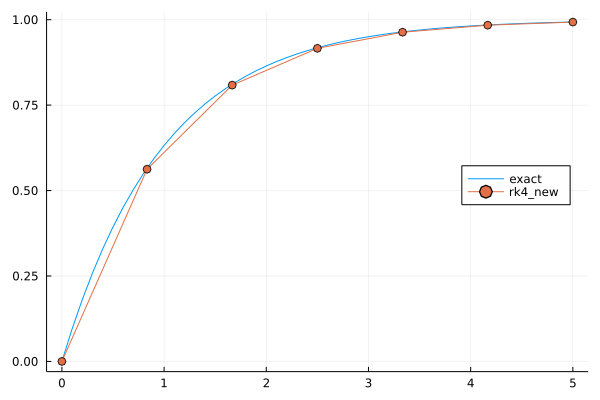

In [30]:
using Plots
t = 0:0.1:5
f(t, x) = 1 - x
t₀, x₀ = 0., 0.
nsteps, tfinal   = 7, 5.0
dt = tfinal / (nsteps-1)
plot(t, 1 .- exp.(-t),label = "exact", legend = :right)
plot!(solver(f, rk4_new, t₀, x₀, dt, nsteps), marker = :o,  label="rk4_new")

In [31]:
a = [  0   0  0  0; 
     1/3   0  0  0; 
    -1/3   1  0  0; 
       1  -1  1  0]

4×4 Matrix{Float64}:
  0.0        0.0  0.0  0.0
  0.333333   0.0  0.0  0.0
 -0.333333   1.0  0.0  0.0
  1.0       -1.0  1.0  0.0

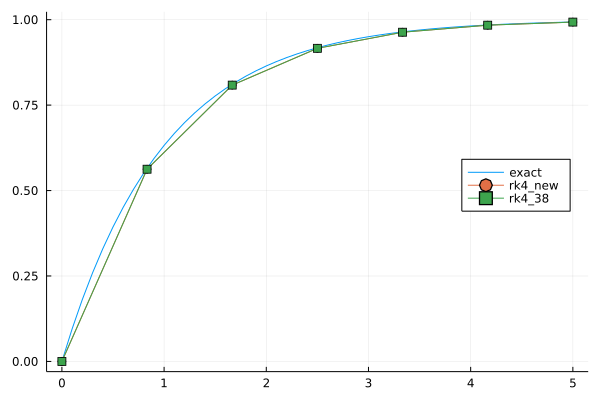

In [32]:
b = [1/8, 3/8, 3/8, 1/8]
c = [0, 1/3,  2/3, 1]
rk4_38 = RungeKutta(a, b, c)
plot!(solver(f, rk4_38, t₀, x₀, dt, nsteps), marker = :r,  label="rk4_38")

## Metaprogrammation

Voyons maintenant comment créer la fonction "solveur" en utilisant la métaprogrammation.

In [33]:
macro addition(x, y)
    return :($x + $y)
end

@addition (macro with 1 method)

In [35]:
@addition 2 3      ## ou @add(2, 3) 

5

Cette macro n'est pas une fonction, elle crée une expression en utilisant les deux arguments et place le symbole `+` entre les deux. Créons maintenant une macro pour calculer la valeur absolue.

In [36]:
macro abs(x)
    return :( $x > 0 ? $x : -$x)
end
@abs(-2), @abs(2)

(2, 2)

Pour des expressions plus longues et plus compliquées, on utilisera le mot-clé `quote`. La macro suivante va créer la fonction solveur avec la méthode numérique choisie.

In [38]:
macro make_method( meth)
    return quote
        function (f::Function, t₀::T, x₀::T, dt::T, nsteps::Int64) where T

            t = zeros(T,nsteps)
            x = zeros(T,nsteps)

            t[1] = t₀
            x[1] = x₀

            for i in 2:nsteps
               t[i], x[i] = $meth(f,t[i-1],x[i-1], dt)
            end

            return t, x
        end
    end
end

@make_method (macro with 1 method)

In [39]:
rk4_solver = @make_method rk4

#5 (generic function with 1 method)

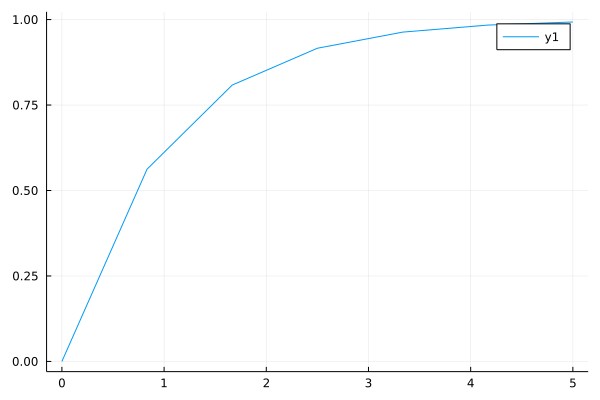

In [40]:
plot(rk4_solver(f, t₀, x₀, dt, nsteps))